In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import rgb_to_hsv
import numpy as np
from collections import defaultdict
from itertools import combinations
import random
import subprocess

In [2]:
gml_path = "Graphs/dolphins.gml"
max_iter = 50_000_000
max_num_group = 64
initial_num_group = 2
saved_data_name = "dolphins_cp"
save_directory = "Outputs/dolphins_moregroups/"

config_path = save_directory + saved_data_name + "_configs.txt"
num_groups_path = save_directory + saved_data_name + "_num_groups.txt"
ll_path = save_directory + saved_data_name + "_ll.txt"

new_values = {
    "gml_path": gml_path,
    "max_itr": max_iter,
    "max_num_groups": max_num_group,
    "initial_num_groups": initial_num_group,
    "saved_data_name": saved_data_name,
    "save_directory": save_directory
}

with open("parameters.txt", "r+") as f:
    lines = f.readlines()
    f.seek(0)
    f.truncate()
    
    for line in lines:
        key = line.split(":")[0].strip()
        if key in new_values:
            f.write(f"{key}: {new_values[key]}\n")
        else:
            f.write(line)

In [3]:
path_exe = "build/hcp.exe"
subprocess.run([path_exe, "parameters.txt"])

CompletedProcess(args=['build/hcp.exe', 'parameters.txt'], returncode=0)

In [4]:
with open(ll_path, "r") as f:
    lines = f.readlines()
    min_ll = float("inf")
    min_ll_index = 0
    for i, line in enumerate(lines):
        ll = float(line.strip())
        if ll < min_ll:
            min_ll = ll
            min_ll_index = i
    print(min_ll, min_ll_index)

with open(config_path, "r") as f:
    lines = f.readlines()
    best_config = lines[min_ll_index].strip()
    best_config = list(map(int, best_config.split()))

with open(num_groups_path, "r") as f:
    lines = f.readlines()
    best_num_groups = int(lines[min_ll_index].strip())

-473.171 18127


Max level: 5


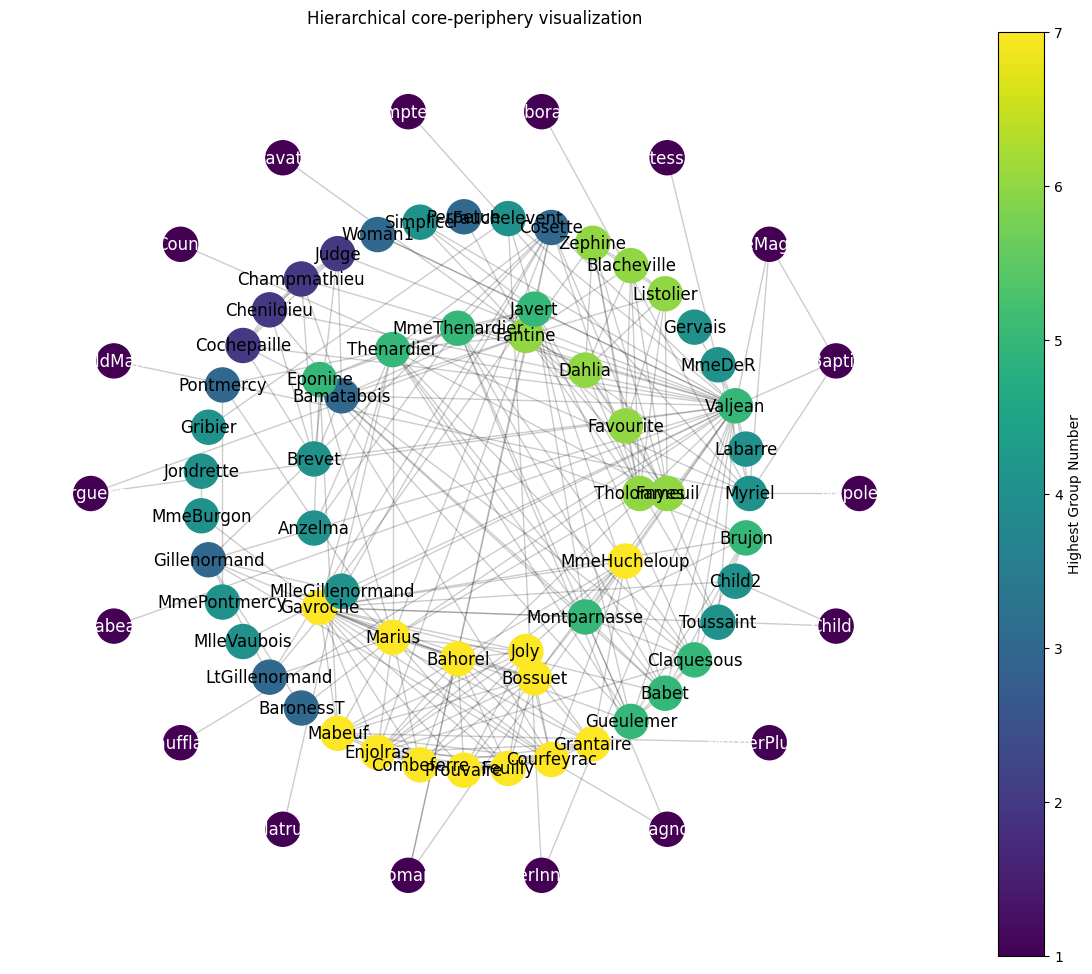

In [19]:
def get_node_groups(number):
    binary = format(number, 'b')[::-1]  # Reverse since right bit has more importance
    return [i for i, bit in enumerate(binary) if bit == '1']

def create_group_based_layout(G, numbers):
    node_list = list(G.nodes())
    node_to_idx = {node: idx for idx, node in enumerate(node_list)}
    idx_to_node = {idx: node for idx, node in enumerate(node_list)}
    
    node_groups = {}
    for i, num in enumerate(numbers):
        if i < len(node_list):
            node_groups[node_list[i]] = get_node_groups(num)
    
    # Calculate hierarchical level based on number of groups a node belongs to
    hierarchy_levels = {node: len(groups) for node, groups in node_groups.items()}
    max_level = max(hierarchy_levels.values()) if hierarchy_levels else 1
    print(f"Max level: {max_level}")
    
    pos = nx.spring_layout(G, k=1, iterations=50)
    # Adjust positions based on hierarchy levels
    for level in range(max_level + 1):
        # Count nodes at this level
        level_nodes = [(i, node) for i, node in enumerate(G.nodes()) if hierarchy_levels.get(node, 0) == level]
        n_level_nodes = len(level_nodes)
        
        if n_level_nodes == 0:
            continue
            
        angle_step = 2 * np.pi / n_level_nodes  # Equal spacing in a circle
        
        # Calculate radius for this level with margin
        margin = 0.1  # Adjust this value to increase or decrease spacing
        if level < max_level:
            base_radius = 1 - (level / max_level)
        else:
            base_radius = 0.25
        radius = base_radius + margin
        
        # Position nodes at this level
        for idx, (i, node) in enumerate(level_nodes):
            theta = idx * angle_step  # Unique angle for each node at this level
            pos[node] = np.array([radius * np.cos(theta), radius * np.sin(theta)])

    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Node sizes based on number of groups
    node_sizes = [600 for node in G.nodes()]
    
    # Node colors based on highest group number
    node_colors = [max(node_groups.get(node, [0])) if node_groups.get(node, []) else 0 
                   for node in G.nodes()]

    nodes = nx.draw_networkx_nodes(G, pos, 
                                   node_size=node_sizes,
                                   node_color=node_colors,
                                   cmap=plt.cm.viridis,
                                   ax=ax)
    
    nx.draw_networkx_edges(G, pos, alpha=0.2, ax=ax)
    
    # Set up colorbar
    norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Highest Group Number")

    # Determine if label color should be white or black based on node color
    labels = {}
    label_colors = {}
    for node in G.nodes():
        color_value = node_colors[node_list.index(node)]  # Get color value for the node
        color_rgb = plt.cm.viridis(norm(color_value))[:3]  # Convert to RGB

        # Convert RGB to HSV to check brightness
        brightness = rgb_to_hsv(np.array([[color_rgb]]))[0, 0, 2]  # Brightness component
        label_color = 'white' if brightness < 0.5 else 'black'
        
        labels[node] = str(node)
        label_colors[node] = label_color

    # Draw labels with adjusted colors
    for node, label in labels.items():
        nx.draw_networkx_labels(G, pos, {node: label}, font_color=label_colors[node], ax=ax)

    plt.title("Hierarchical core-periphery visualization")
    plt.axis('off')
    
    return G, pos

# Load the graph and plot
G = nx.read_gml(gml_path)
G, pos = create_group_based_layout(G, best_config)
plt.show()


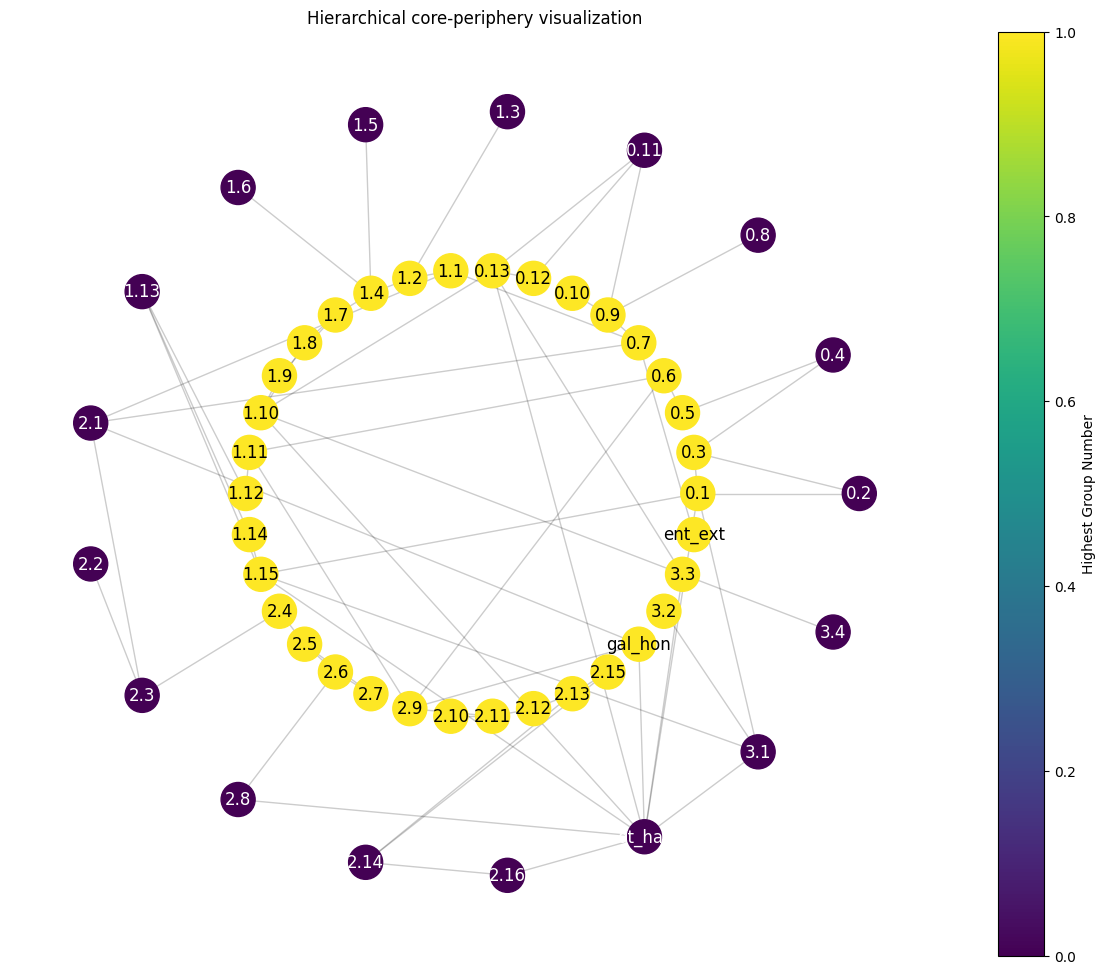

In [14]:
G, pos = create_group_based_layout(G, best_config)
plt.show()

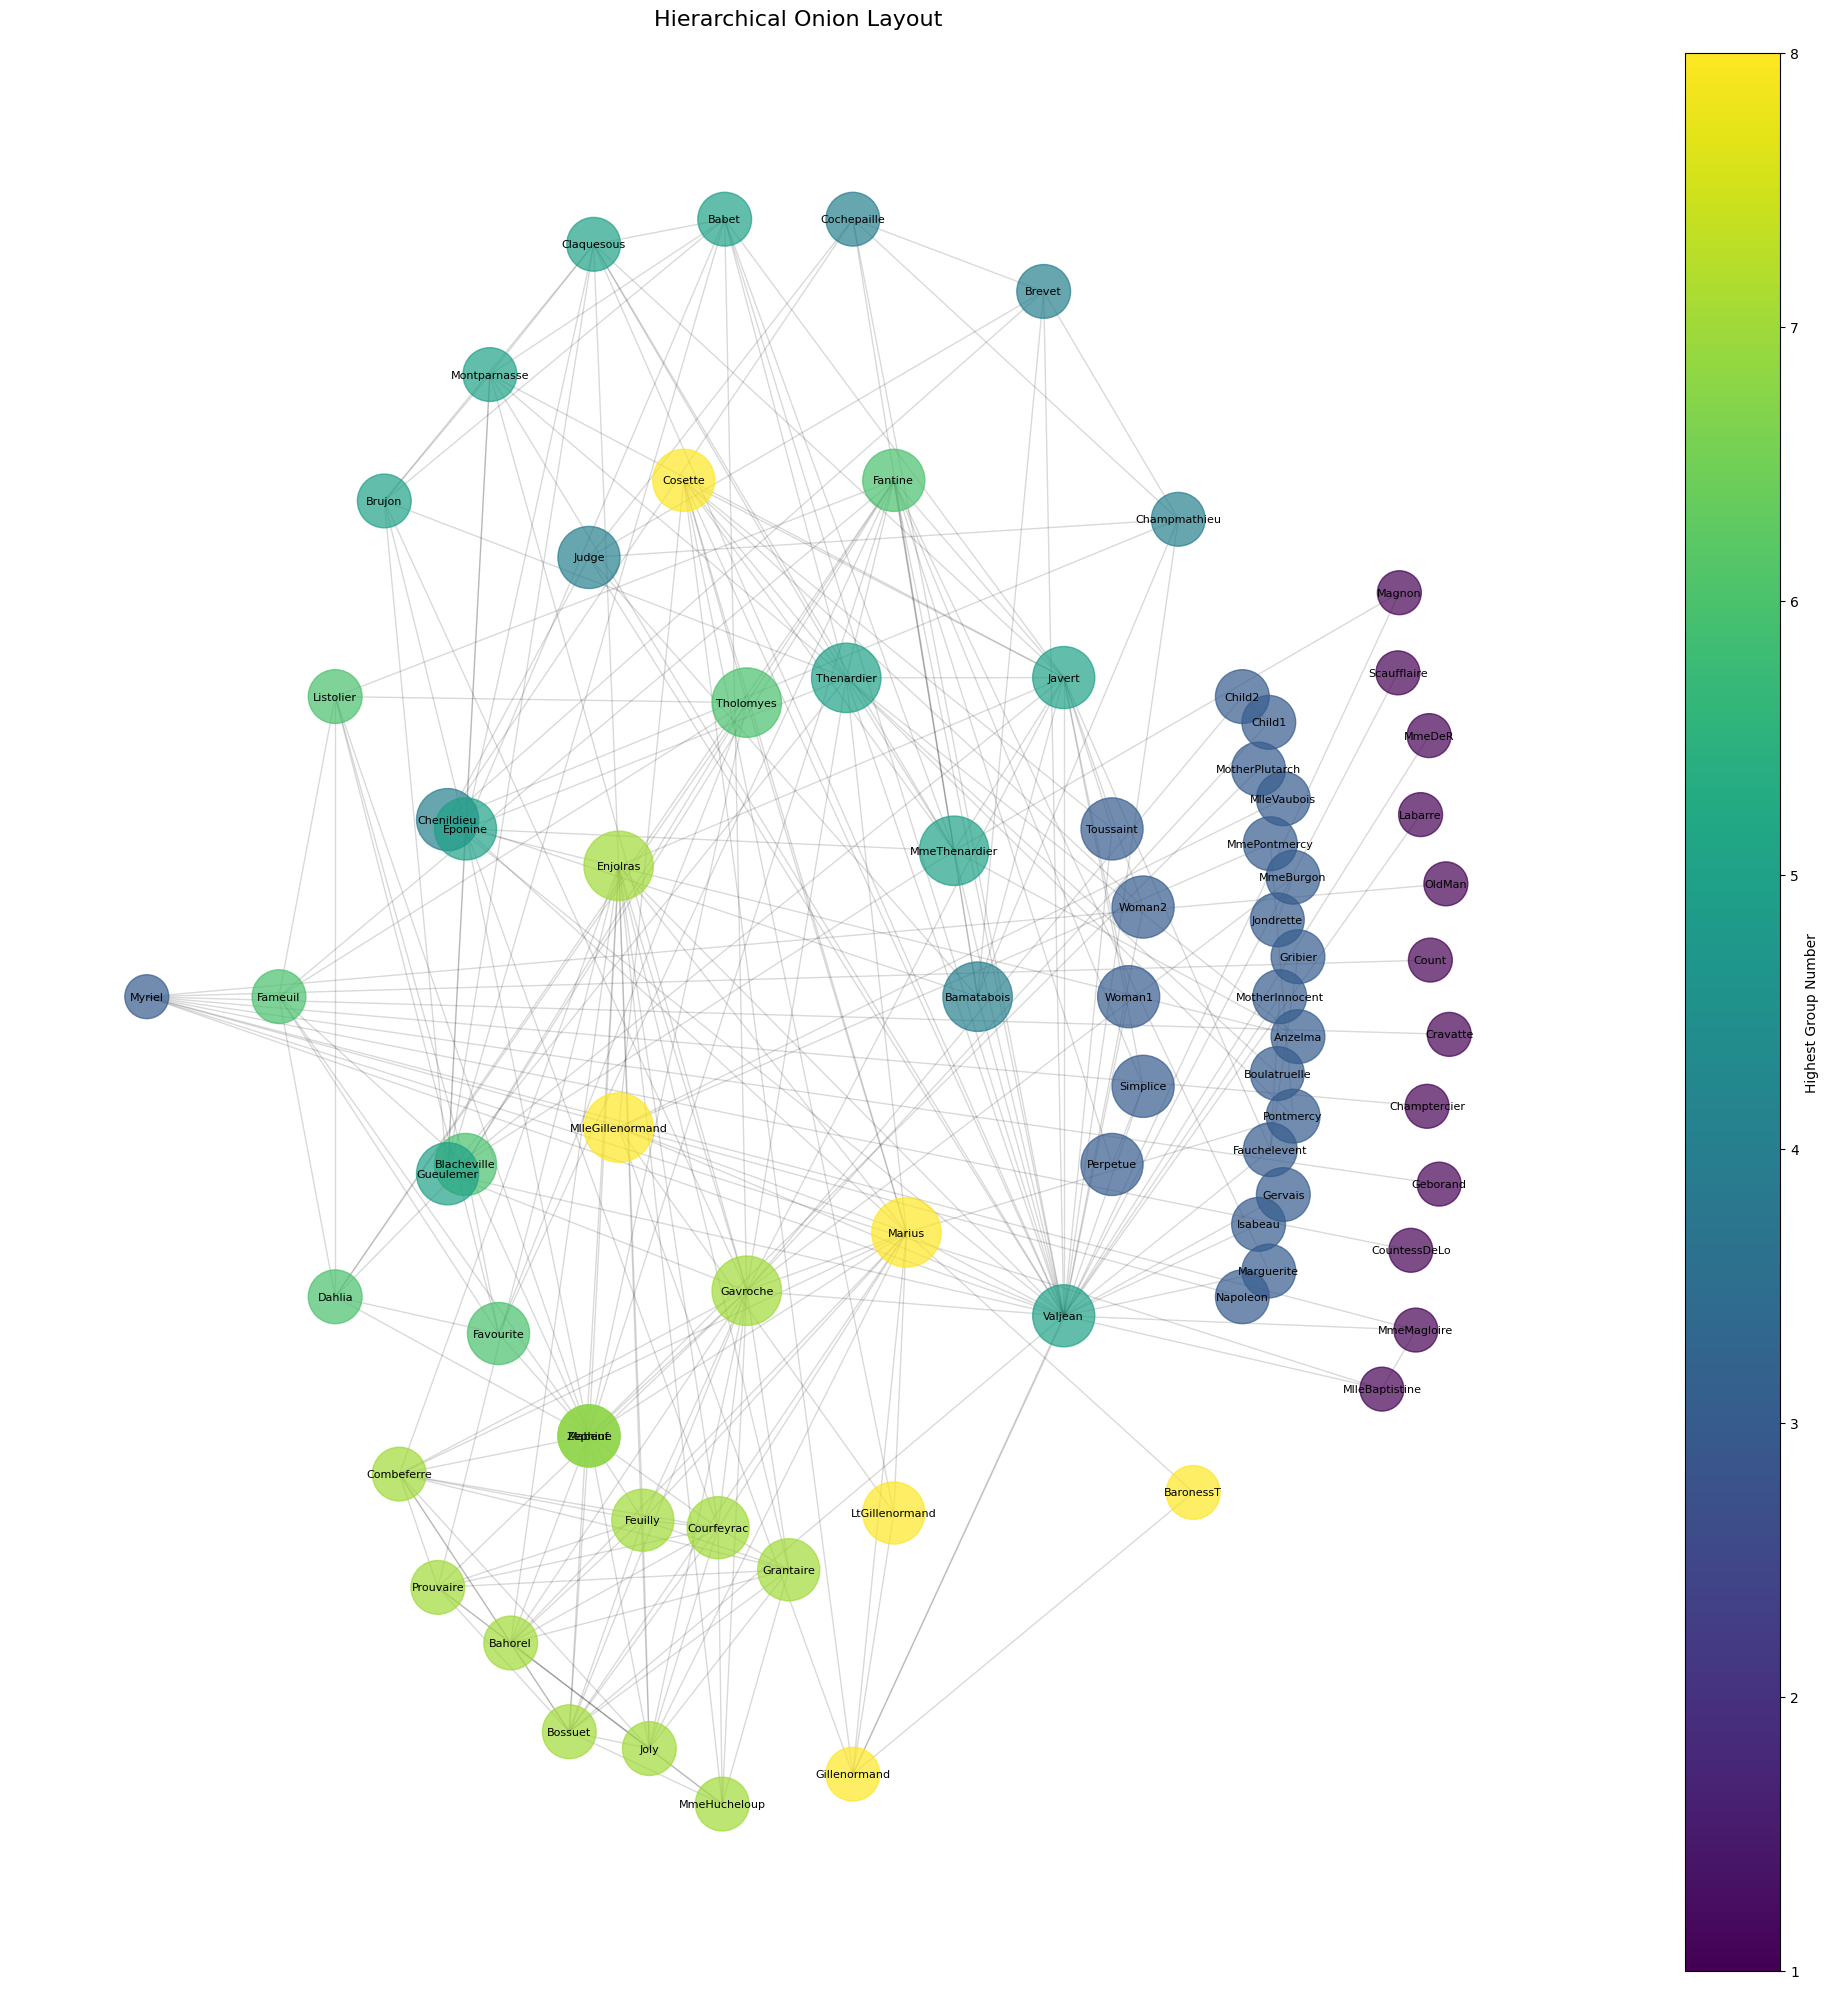

In [56]:
def get_node_groups(number):
    """Convert a decimal number to its binary representation and return indices where 1s appear"""
    binary = format(number, 'b')[::-1]  # Reverse since right bit has more importance
    return [i for i, bit in enumerate(binary) if bit == '1']

def create_onion_layout(G, numbers):
    # Create a mapping between original node names and indices
    node_list = list(G.nodes())
    
    # Get groups for each node and organize nodes by their binary pattern
    node_groups = {}
    pattern_to_nodes = defaultdict(list)
    
    for i, num in enumerate(numbers):
        if i < len(node_list):
            groups = get_node_groups(num)
            node_groups[node_list[i]] = groups
            pattern_to_nodes[tuple(sorted(groups))].append(node_list[i])
    
    # Create figure and axis with larger size
    fig, ax = plt.subplots(figsize=(20, 20))
    
    # Initialize positions dictionary
    pos = {}
    
    # Sort patterns by number of groups (for layers) and then by the specific groups
    patterns_by_level = defaultdict(list)
    for pattern in pattern_to_nodes.keys():
        patterns_by_level[len(pattern)].append(pattern)
    
    # Sort levels from most groups (inner circle) to least groups (outer circle)
    levels = sorted(patterns_by_level.keys(), reverse=True)
    max_level = max(levels)
    
    # Calculate positions for each level
    for level_idx, level in enumerate(levels):
        patterns_in_level = sorted(patterns_by_level[level])
        num_patterns_in_level = len(patterns_in_level)
        
        # Base radius for this level (creates the onion-like structure)
        base_radius = 0.2 + (1 - level/max_level) * 0.8  # Adjusted to start from 0.2 to avoid center crowding
        
        # Position each pattern group in this level
        for pattern_idx, pattern in enumerate(patterns_in_level):
            nodes_in_pattern = pattern_to_nodes[pattern]
            num_nodes = len(nodes_in_pattern)
            
            # Calculate base angle for this pattern group
            base_angle = (2 * np.pi * pattern_idx) / num_patterns_in_level
            
            # Calculate arc length for this group based on number of nodes
            arc_length = 2 * np.pi / num_patterns_in_level
            arc_length = min(arc_length, np.pi/4)  # Limit arc length to prevent spreading too wide
            
            # Position nodes within the pattern group
            for node_idx, node in enumerate(nodes_in_pattern):
                # Calculate angle within the pattern's arc
                if num_nodes > 1:
                    angle = base_angle + (arc_length * node_idx / (num_nodes - 1) - arc_length/2)
                else:
                    angle = base_angle
                
                # Add small radius variation to prevent exact overlaps
                radius = base_radius + 0.02 * (node_idx % 2)
                
                x = radius * np.cos(angle)
                y = radius * np.sin(angle)
                pos[node] = np.array([x, y])
    
    # Node sizes (smaller to reduce overlap)
    node_sizes = [2500 * (len(node_groups.get(node, [])) / max_level) 
                 for node in G.nodes()]
    
    # Node colors based on highest group number
    node_colors = [max(node_groups.get(node, [0])) if node_groups.get(node, []) else 0 
                  for node in G.nodes()]
    
    # Create the visualization
    nodes = nx.draw_networkx_nodes(G, pos, 
                                 node_size=node_sizes,
                                 node_color=node_colors,
                                 cmap=plt.cm.viridis,
                                 alpha=0.7,
                                 ax=ax)
    
    # Draw edges with reduced alpha to reduce visual clutter
    nx.draw_networkx_edges(G, pos, alpha=0.15, width=1, ax=ax)
    
    # Add labels with smaller font size
    labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    
    # Set up colorbar
    norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label="Highest Group Number")
    
    plt.title("Hierarchical Onion Layout", fontsize=16, pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    return G, pos
G = nx.read_gml('Graphs/lesmiserables.gml')
G, pos = create_onion_layout(G, last_line_configs)
plt.show()

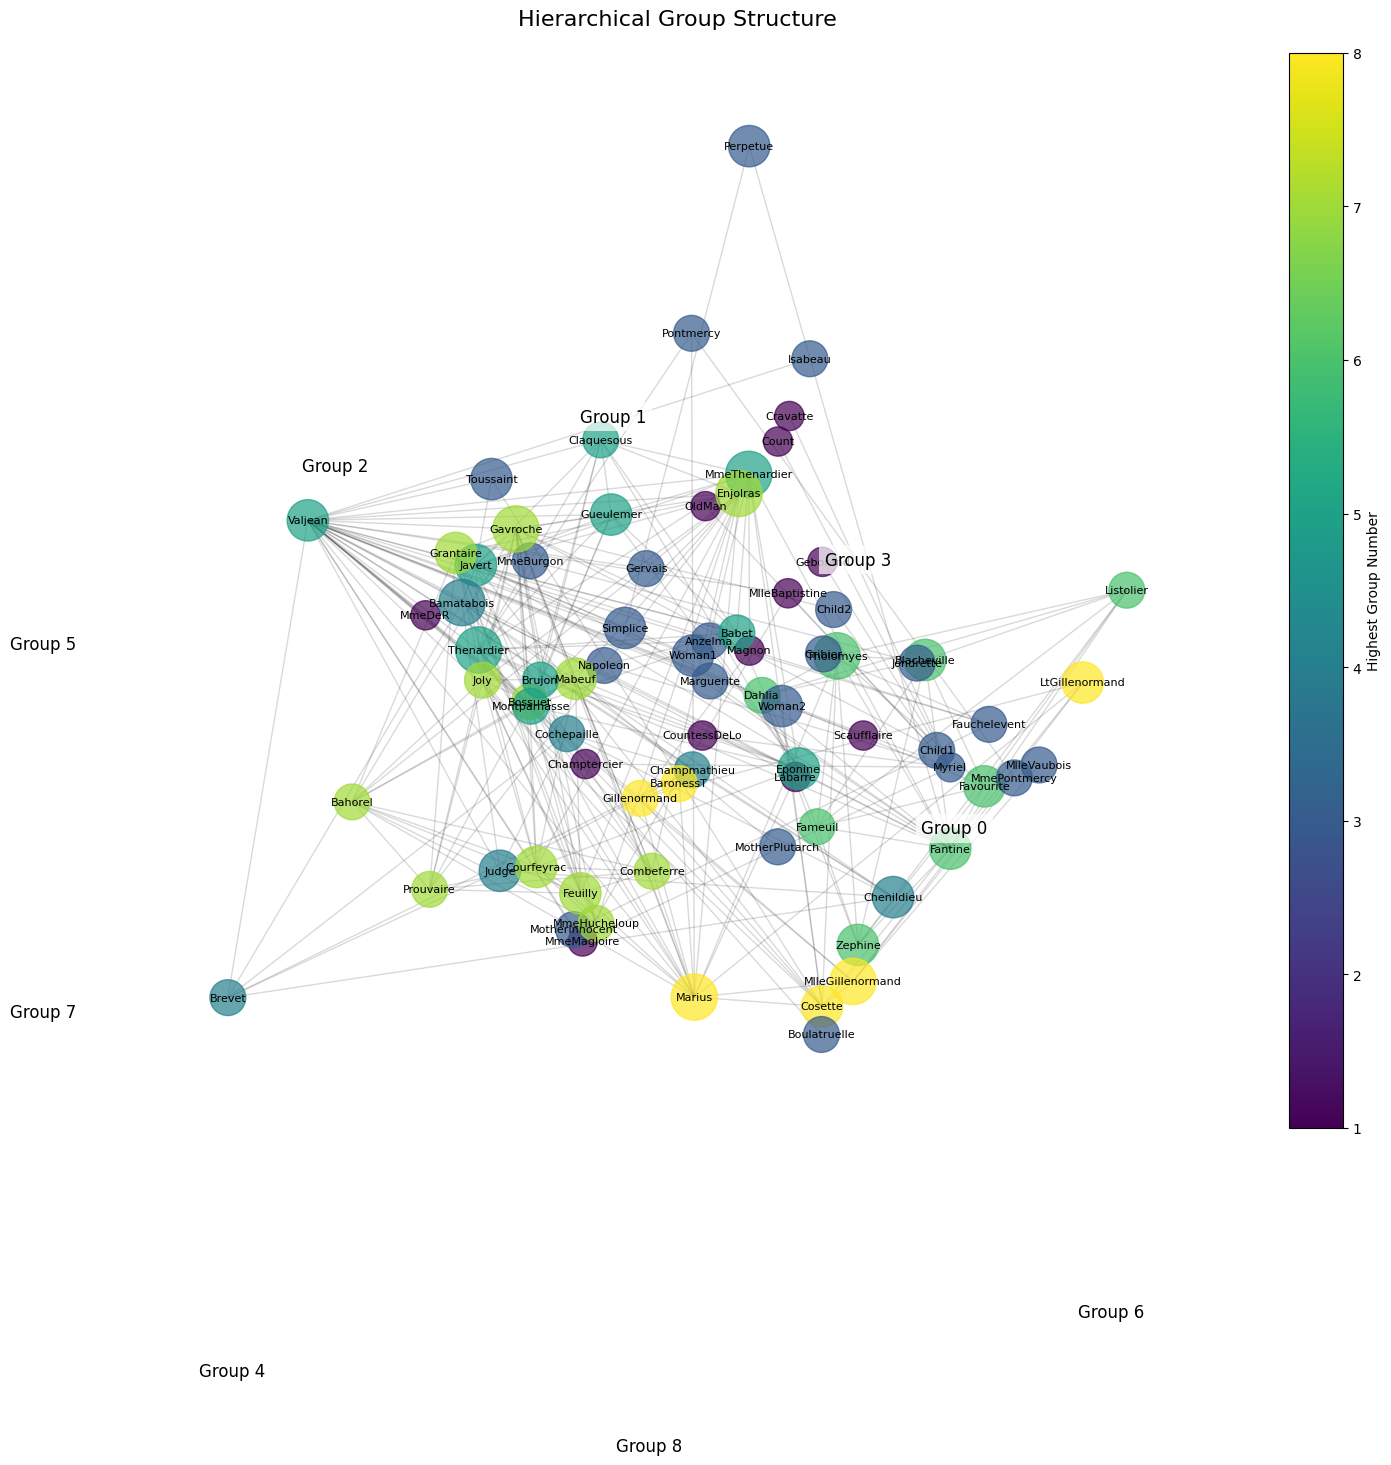

In [57]:
def get_node_groups(number):
    """Convert a decimal number to its binary representation and return indices where 1s appear"""
    binary = format(number, 'b')[::-1]  # Reverse since right bit has more importance
    return [i for i, bit in enumerate(binary) if bit == '1']

def analyze_group_hierarchy(numbers):
    """Analyze the hierarchical relationships between groups based on binary patterns"""
    # Get all unique groups that nodes belong to
    all_groups = set()
    node_patterns = []
    
    for num in numbers:
        groups = get_node_groups(num)
        all_groups.update(groups)
        node_patterns.append(tuple(sorted(groups)))
    
    # Create hierarchy dictionary showing which groups contain others
    hierarchy = defaultdict(set)
    group_counts = defaultdict(int)
    
    # Count how many times each group appears
    for pattern in node_patterns:
        for group in pattern:
            group_counts[group] += 1
            
        # Track which groups appear together
        for g1, g2 in combinations(pattern, 2):
            hierarchy[g1].add(g2)
            hierarchy[g2].add(g1)
    
    return dict(hierarchy), dict(group_counts)

def create_hierarchical_layout(G, numbers):
    """Create a hierarchical group layout based on binary patterns"""
    # Get node groups
    node_groups = {}
    pattern_to_nodes = defaultdict(list)
    
    for i, num in enumerate(numbers):
        if i < len(G.nodes()):
            node = list(G.nodes())[i]
            groups = get_node_groups(num)
            node_groups[node] = groups
            pattern_to_nodes[tuple(sorted(groups))].append(node)
    
    # Analyze group hierarchy
    hierarchy, group_counts = analyze_group_hierarchy(numbers)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Calculate group positions based on hierarchy
    group_positions = {}
    angle_step = 2 * np.pi / max(1, len(hierarchy))
    
    # Position groups in a circle with the most connected groups closer to center
    for i, (group, connected) in enumerate(sorted(hierarchy.items(), 
                                                key=lambda x: len(x[1]), 
                                                reverse=True)):
        # More connected groups should be more central
        radius = 1.0 / (1 + len(connected))
        angle = i * angle_step
        group_positions[group] = (radius * np.cos(angle), radius * np.sin(angle))
    
    # If there are isolated groups, position them on the outer circle
    all_groups = set(range(max(max(hierarchy.keys(), default=-1), 
                          max([max(g) for g in node_groups.values()], default=-1) + 1)))
    for group in all_groups:
        if group not in group_positions:
            angle = len(group_positions) * angle_step
            group_positions[group] = (np.cos(angle), np.sin(angle))
    
    # Position nodes based on their group memberships
    pos = {}
    for node, groups in node_groups.items():
        if not groups:
            groups = [0]
        
        # Calculate position as average of group positions with small random offset
        x = sum(group_positions[g][0] for g in groups) / len(groups)
        y = sum(group_positions[g][1] for g in groups) / len(groups)
        
        # Add small random offset to prevent overlaps
        pos[node] = np.array([x + np.random.normal(0, 0.05),
                            y + np.random.normal(0, 0.05)])
    
    # Draw network
    node_sizes = [2000 * (len(node_groups.get(node, [])) / len(all_groups)) 
                 for node in G.nodes()]
    
    node_colors = [max(node_groups.get(node, [0])) if node_groups.get(node, []) else 0 
                  for node in G.nodes()]
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=node_sizes,
                                 node_color=node_colors,
                                 cmap=plt.cm.viridis,
                                 alpha=0.7,
                                 ax=ax)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.15, width=1, ax=ax)
    
    # Add node labels
    labels = {node: str(node) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    
    # Add group labels
    for group, (x, y) in group_positions.items():
        plt.text(x * 1.1, y * 1.1, f'Group {group}',
                horizontalalignment='center',
                fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Set up colorbar
    norm = Normalize(vmin=min(node_colors), vmax=max(node_colors))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Highest Group Number")
    
    plt.title("Hierarchical Group Structure", fontsize=16, pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    return G, pos

# Example usage:
G = nx.read_gml('Graphs/lesmiserables.gml')
G, pos = create_hierarchical_layout(G, last_line_configs)
plt.show()